In [1]:
# Note that there is a fudge factor depending on how the data is read.
# I probably underestimate variance by a factor of 3.
# Relevant 

from NIX_Testing import NIX_Image_List, NIX_Image
from pylab import *
from astropy.io import fits
from lmfit.models import PolynomialModel

data_dir = '/home/ydallilar/Documents/NIX/nixDetBackup'

test_ids = ['PER-124-04-1']
config = {'test_ids' : test_ids, 'data_dir' : data_dir}
NIX_GL = NIX_Image_List(config)

In [2]:
BP_Mask = NIX_Image('BP_mask.fits')

In [3]:
sz = len(NIX_GL)/2

ims = zeros([2048, 2048, sz/2])
diffs = zeros([2048, 2048, sz/2])

for i in range(sz/2):
    ims[:,:,i] = NIX_GL[2*i+40].getImage(mask=BP_Mask)-NIX_GL[2*i].getImage(mask=BP_Mask)
    diffs[:,:,i] = NIX_GL[2*i+41].getImage(mask=BP_Mask)-NIX_GL[2*i+40].getImage(mask=BP_Mask)

ims[where(ims == 0)] = NaN
diffs[where(diffs == 0)] = NaN


Text(0.5,0,'Apparent Signal (ADU)')

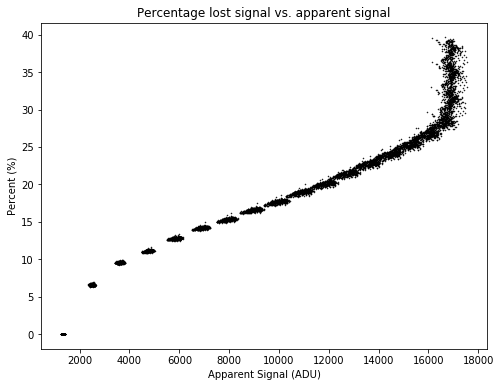

In [4]:
signals = []
true_signal = []

exp = (arange(20)+1)*2

for i in range(20):
    for j in range(20):
        for k in range(sz/2):
            true_signal.append(nanmedian(ims[500+50*i-25:500+50*i+25,
                            500+50*j-25:500+50*j+25, 0]*(k+1)))
            signals.append(nanmedian(ims[500+50*i-25:500+50*i+25,
                            500+50*j-25:500+50*j+25, k]))


signals = array(signals)
true_signal = array(true_signal)

figure(figsize=(8,6))
plot(signals, (1-signals/true_signal)*100., 'k.', markersize=1.)
title("Percentage lost signal vs. apparent signal")
ylabel("Percent (%)")
xlabel("Apparent Signal (ADU)")


[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 6292
    # variables        = 4
    chi-square         = 24823956.1
    reduced chi-square = 3947.83017
    Akaike info crit   = 52107.5561
    Bayesian info crit = 52134.5442
[[Variables]]
    c0:  0 (fixed)
    c1:  0.98882676 +/- 0.00177928 (0.18%) (init = 1.091436)
    c2:  3.8251e-05 +/- 5.8994e-07 (1.54%) (init = 1.696847e-05)
    c3: -2.5856e-09 +/- 6.1175e-11 (2.37%) (init = -8.753314e-10)
    c4:  1.0406e-13 +/- 1.9922e-15 (1.91%) (init = 5.722845e-14)
[[Correlations]] (unreported correlations are < 0.100)
    C(c3, c4) = -0.993
    C(c2, c3) = -0.987
    C(c1, c2) = -0.970
    C(c2, c4) =  0.960
    C(c1, c3) =  0.920
    C(c1, c4) = -0.872


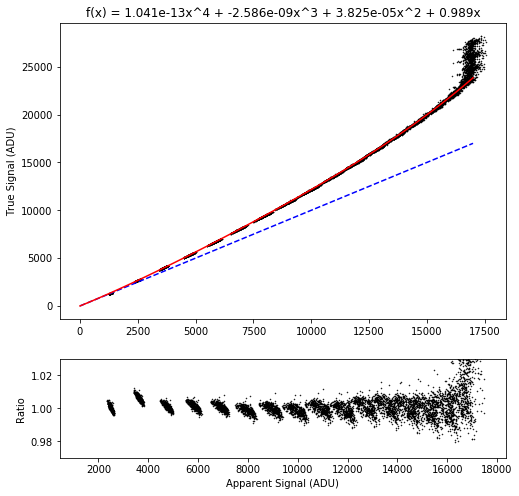

In [5]:
order = 4

ndx = where(signals < 16000)[0]

model = PolynomialModel(order)
pars = model.guess(true_signal[ndx], x=signals[ndx])
pars['c0'].set(value=0., vary=False)

out = model.fit(true_signal[ndx], pars, x=signals[ndx])

print out.fit_report()

pol = poly1d([out.best_values['c%d' % i] for i in range(order+1)[::-1]])

xx = linspace(0, 17000, 100)

f, (a1, a2) = subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,8))

a1.plot(signals, true_signal, 'k.', markersize=1.)
a1.plot(xx, xx, 'b--')
a1.plot(xx, pol(xx), 'r-')
a1.set_ylabel('True Signal (ADU)')
a1.set_title('f(x) = %.3ex^4 + %.3ex^3 + %.3ex^2 + %.3fx' % \
             tuple([out.best_values['c%d' % i ] for i in range(1,5)[::-1]]))

a2.plot(signals, true_signal/pol(signals), 'k.', markersize=1.)
a2.set_ylabel('Ratio')
a2.set_xlabel('Apparent Signal (ADU)')
a2.set_ylim([0.97, 1.03])

show()


In [6]:
for i in range(sz/2):
    ims[:,:,i] = pol(NIX_GL[2*i+40].getImage(mask=BP_Mask)-NIX_GL[2*i].getImage(mask=BP_Mask))
    diffs[:,:,i] = pol(NIX_GL[2*i+41].getImage(mask=BP_Mask)-NIX_GL[2*i].getImage(mask=BP_Mask)) \
                -pol(NIX_GL[2*i+40].getImage(mask=BP_Mask)-NIX_GL[2*i].getImage(mask=BP_Mask))    
    
ims[where(ims == 0)] = NaN
diffs[where(diffs == 0)] = NaN

stds = []
signals = []

for i in range(20):
    for j in range(20):
        for k in range(sz/2):
            stds.append(nanstd(diffs[500+50*i-25:500+50*i+25,
                            500+50*j-25:500+50*j+25, k])/sqrt(2))
            signals.append(nanmedian(ims[500+50*i-25:500+50*i+25,
                            500+50*j-25:500+50*j+25, k]))

ndx = where(array(signals) < 16000)[0]

[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 4566
    # variables        = 1
    chi-square         = 4.49725127
    reduced chi-square = 9.8516e-04
    Akaike info crit   = -31608.0822
    Bayesian info crit = -31601.6558
[[Variables]]
    c0: -0.61765578 +/- 4.6450e-04 (0.08%) (init = -0.4301267)
    c1:  0.5 (fixed)
Gain : 17.2 e-/ADU


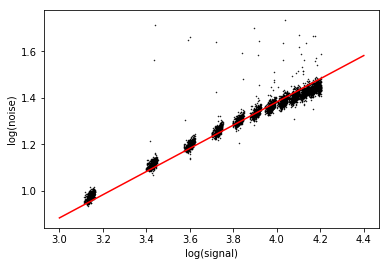

In [7]:
order = 1

log_signal = log10(signals)
log_std = log10(stds)

model = PolynomialModel(order)
pars = model.guess(log_std[ndx], x=log_signal[ndx])
pars['c1'].set(value=0.5, vary=False)

out = model.fit(log_std[ndx], pars, x=log_signal[ndx])

print out.fit_report()

xx = linspace(3, 4.4, 100)
pol = poly1d([out.best_values['c%d' % i] for i in range(order+1)[::-1]])


plt.figure()
plot(log_signal[ndx], log_std[ndx], 'k.', markersize=1.)
plot(xx, pol(xx), 'r-')
ylabel('log(noise)')
xlabel('log(signal)')

gain1 = 10**(-out.best_values['c0']*2)

print "Gain : %.1f e-/ADU" % gain1

show()


[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 4566
    # variables        = 1
    chi-square         = 1.7987e+10
    reduced chi-square = 3940151.46
    Akaike info crit   = 69343.6078
    Bayesian info crit = 69350.0342
[[Variables]]
    c0:  0 (fixed)
    c1:  17.3462846 +/- 0.05522508 (0.32%) (init = 16.13828)
Gain : 17.3 e-/ADU


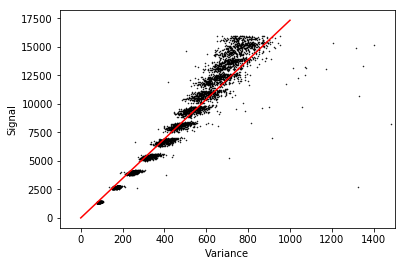

In [8]:
order = 1

vars = array(stds)**2
signals = array(signals)

model = PolynomialModel(order)
pars = model.guess(signals[ndx], x=vars[ndx])
pars['c0'].set(value=0., vary=False)

out = model.fit(signals[ndx], pars, x=vars[ndx])

print out.fit_report()

xx = linspace(0, 1000, 100)
pol = poly1d([out.best_values['c%d' % i] for i in range(order+1)[::-1]])

plt.figure()
plot(vars[ndx], signals[ndx], 'k.', markersize=1.)
#plot(vars[ndx], signals[ndx], 'r.', markersize=1.)
plot(xx, pol(xx), 'r-')
ylabel('Signal')
xlabel('Variance')
plt.xlim([-100, 1500])

gain2 = out.best_values['c1']

print "Gain : %.1f e-/ADU" % (gain2)

In [9]:
ims = zeros([2048, 2048, sz/2])
diffs = zeros([2048, 2048, sz/2])

for i in range(sz/2):
    ims[:,:,i] = NIX_GL[2*i].getImage(mask=BP_Mask)-NIX_GL[0].getImage(mask=BP_Mask)
    diffs[:,:,i] = NIX_GL[2*i+1].getImage(mask=BP_Mask)-NIX_GL[2*i].getImage(mask=BP_Mask)

ims[where(ims == 0)] = NaN
diffs[where(diffs == 0)] = NaN

stds = []
signals = []
exps = []

for i in range(20):
    for j in range(20):
        for k in range(sz/2):
            stds.append(nanstd(diffs[500+50*i-25:500+50*i+25,
                            500+50*j-25:500+50*j+25, k])/sqrt(2))
            signals.append(nanmedian(ims[500+50*i-25:500+50*i+25,
                            500+50*j-25:500+50*j+25, k]))
            exps.append(2*k+2)
            
stds = array(stds)
signals = array(signals)
exps = array(exps)

/home/ydallilar/.miniconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Read Noise : 2.71 +/- 0.09 ADU (or 46.64 +/- 1.57 e-)


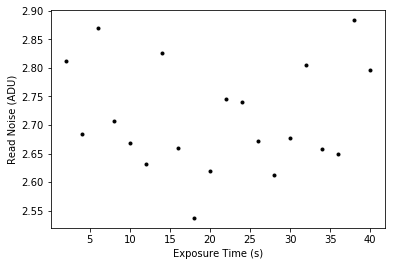

In [10]:
stds_r = stds.reshape([400, sz/2])
RNs = median(stds_r, axis=0)
RN_std = std(stds_r, axis=0)
exp_r = exps.reshape([400, sz/2])

figure()
plot(exp_r[0,:], RNs, 'k.')
ylabel('Read Noise (ADU)')
xlabel('Exposure Time (s)')

print "Read Noise : %.2f +/- %.2f ADU (or %.2f +/- %.2f e-)" % (mean(RNs), std(RNs), gain1*mean(RNs), gain1*std(RNs)) 
